In [188]:
import pandas as pd
# 导入扩展库
import re                           # 正则表达式库
import jieba                        # 结巴分词
import jieba.posseg                 # 词性获取
import collections                  # 词频统计库
import numpy                        # numpy数据处理库
from PIL import Image               # 图像处理库
import wordcloud                    # 词云展示库
import os
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import joblib

In [189]:
df = pd.read_csv('data/礼物长尾词_1606095511.csv')

C:\Users\wyf35\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [190]:
df = df.sort_values(by='长尾词数量',ascending=False)

In [191]:
df = df.rename(columns={'关键词':'word', '长尾词数量':'lenword_count','PC日检索量(VIP特权数据)':'searched_day'})

In [192]:
df.head(20)

,word,lenword_count,搜索结果,SEM点击价格(SVIP特权数据),流量特点(SVIP特权数据),流量指数(VIP特权数据),移动指数(VIP特权数据),360指数(VIP特权数据),竞价公司数量(VIP特权数据),searched_day,移动日检索量(VIP特权数据),竞价竞争激烈程度(VIP特权数据)
939,《礼物》,4466347.0,47900000,NaN,NaN,0,0,0,-,3,9,3
88289,礼物(),4466347.0,26600000,NaN,NaN,未收录,未收录,0,-,-,-,-
938,《礼物,4466347.0,1500000,NaN,NaN,0,0,0,-,-,-,11
88287,《礼物》礼物,4466347.0,26700000,NaN,NaN,未收录,未收录,0,-,-,-,-
940,()礼物,4466347.0,17500000,NaN,NaN,0,0,0,-,-,-,-
88288,《 礼物 》,4466347.0,1980000,NaN,NaN,未收录,未收录,未收录,-,-,-,-
937,礼物礼物,4466347.0,367000,NaN,NaN,0,0,0,-,1,4,2
3,礼物,4466347.0,100000000,NaN,NaN,1420,968,18704,72,761,1232,1
88290,() 的礼物,1354732.0,100000000,NaN,NaN,未收录,未收录,未收录,-,-,-,-
88291,()()的礼物,1354698.0,26700000,NaN,NaN,未收录,未收录,0,-,-,-,-


#### 数据预清洗
* 基于PC日检索量(VIP特权数据)来进行初步清洗，筛选出有有效值的数据
* word清洗：去掉word中的特殊字符，并去重

In [193]:
used_df = df[['word','lenword_count','searched_day']]

used_df = used_df[used_df['searched_day'] != '-']

In [194]:
used_df.head(20)

,word,lenword_count,searched_day
939,《礼物》,4466347.0,3
937,礼物礼物,4466347.0,1
3,礼物,4466347.0,761
941,的礼物,1339503.0,2
942,礼物的,1339503.0,1
236,什么礼物,1133560.0,4
946,礼物送什么,613979.0,1
188,送什么礼物,613979.0,11
88292,生日 礼物,562027.0,1
947,礼物生日,562027.0,1


In [195]:
# 去掉word中的特殊字符
def remove_col_str(df,col):

    df[col].replace('\n\u4e00-\u9fa5\u0030-\u0039\u0041-\u005a\u0061-\u007a', '', regex=True, inplace=True)
    df[col].replace(' &#.*' , '', regex=True, inplace=True)
    df[col].replace('《|》| |~|，|？|。|（|）|、', '', regex=True, inplace=True)


remove_col_str(used_df,'word')

# 去重
used_df = used_df.sort_values(by='searched_day',ascending=False).drop_duplicates(['word'],keep='first')
used_df = used_df.sort_values(by='lenword_count',ascending=False)

In [196]:
used_df.head(20)

,word,lenword_count,searched_day
937,礼物礼物,4466347.0,1
3,礼物,4466347.0,761
941,的礼物,1339503.0,2
942,礼物的,1339503.0,1
236,什么礼物,1133560.0,4
946,礼物送什么,613979.0,1
188,送什么礼物,613979.0,11
947,礼物生日,562027.0,1
948,生日礼物礼物,419978.0,38
5,生日礼物,414291.0,803


#### jieba分词、实体识别

In [197]:
used_df['word'].describe()

count           7211
unique          7211
top       买什么礼物让老婆高兴
freq               1
Name: word, dtype: object

In [198]:
import jieba
import jieba.posseg as pseg
import re

In [59]:
# 英文词性转中文词性字典：详细版
En2Cn = {
    'a'    : '形容词',
    'ad'   : '形容词-副形词',
    'ag'   : '形容词-形容词性语素',
    'al'   : '形容词-形容词性惯用语',
    'an'   : '形容词-名形词',
    'b'    : '区别词',
    'bl'   : '区别词-区别词性惯用语',
    'c'    : '连词',
    'cc'   : '连词-并列连词',
    'd'    : '副词',
    'e'    : '叹词',
    'eng'  : '英文',
    'f'    : '方位词',
    'g'    : '语素',
    'h'    : '前缀',
    'i'    : '成语',
    'j'    : '简称略语',
    'k'    : '后缀',
    'l'    : '习用语',
    'm'    : '数词',
    'mq'   : '数量词',
    'n'    : '名词',
    'ng'   : '名词-名词性语素',
    'nl'   : '名词-名词性惯用语',
    'nr'   : '名词-人名',
    'nr1'  : '名词-汉语姓氏',
    'nr2'  : '名词-汉语名字',
    'nrf'  : '名词-音译人名',
    'nrfg' : '名词-人名',    
    'nrj'  : '名词-日语人名',
    'ns'   : '名词-地名',
    'nsf'  : '名词-音译地名',
    'nt'   : '名词-机构团体名',
    'nz'   : '名词-其他专名',
    'o'    : '拟声词',
    'p'    : '介词',
    'pba'  : '介词-“把”',
    'pbei' : '介词-“被”',
    'q'    : '量词',
    'qt'   : '量词-动量词',
    'qv'   : '量词-时量词',
    'r'    : '代词',
    'rg'   : '代词-代词性语素',
    'rr'   : '代词-人称代词',
    'rz'   : '代词-指示代词',
    'rzs'  : '代词-处所指示代词',
    'rzt'  : '代词-时间指示代词',
    'rzv'  : '代词-谓词性指示代词',
    'ry'   : '代词-疑问代词',
    'rys'  : '代词-处所疑问代词',
    'ryt'  : '代词-时间疑问代词',
    'ryv'  : '代词-谓词性疑问代词',
    's'    : '处所词',
    't'    : '时间词',
    'tg'   : '时间词-时间词性语素',
    'u'    : '助词',
    'ude1' : '助词-“的”“底”',
    'ude2' : '助词-“地”',
    'ude3' : '助词-“得”',
    'udeng': '助词-“等”“等等”“云云”',
    'udh'  : '助词-“的话”',
    'uguo' : '助词-“过”',
    'ule'  : '助词-“了”“喽”',
    'ulian': '助词-“连”',
    'uls'  : '助词-“来讲”“来说”“而言”“说来”',
    'usuo' : '助词-“所”',
    'uyy'  : '助词-“一样”“一般”“似的”“般”',
    'uzhe' : '助词-“着”',
    'uzhi' : '助词-“之”',
    'v'    : '动词',
    'vd'   : '动词-副动词',
    'vf'   : '动词-趋向动词',
    'vg'   : '动词-动词性语素',
    'vi'   : '动词-不及物动词（内动词）',
    'vl'   : '动词-动词性惯用语',
    'vn'   : '动词-名动词',
    'vshi' : '动词-“是”',
    'vx'   : '动词-形式动词',
    'vyou' : '动词-“有”',
    'w'    : '标点符号',
    'wb'   : '标点符号-百分号千分号，全角：％ ‰ 半角：%',
    'wd'   : '标点符号-逗号，全角：， 半角：,',
    'wf'   : '标点符号-分号，全角：； 半角： ; ',
    'wj'   : '标点符号-句号，全角：。',
    'wh'   : '标点符号-单位符号，全角：￥ ＄ ￡ ° ℃ 半角 $',
    'wkz'  : '标点符号-左括号，全角：（ 〔 ［ ｛ 《 【 〖 〈 半角：( [ { <',
    'wky'  : '标点符号-右括号，全角：） 〕 ］ ｝ 》 】 〗 〉 半角： ) ] { >',
    'wm'   : '标点符号-冒号，全角：： 半角： :',
    'wn'   : '标点符号-顿号，全角：、',
    'wp'   : '标点符号-破折号，全角：—— －－ ——－ 半角：—',
    'ws'   : '标点符号-省略号，全角：…… …',
    'wt'   : '标点符号-叹号，全角：！ 半角：!',
    'ww'   : '标点符号-问号，全角：？ 半角：?',
    'wyz'  : '标点符号-左引号，全角：“ ‘ 『',
    'wyy'  : '标点符号-右引号，全角：” ’ 』',
    'x'    : '字符串',
    'xu'   : '字符串-网址URL',
    'xx'   : '字符串-非语素字',
    'y'    : '语气词',
    'z'    : '状态词',
    'un'   : '未知词',
    'zg'   : '状态词素',
    'nrt'  : '人名-未知'
}


In [209]:
# 停用词
# 创建停用词列表
def get_stopwords_list(file_name):
    stopwords = [line.strip() for line in open(file_name,encoding='UTF-8').readlines()]
    return stopwords

# 对句子进行中文分词
def seg_depart(sentence,stopwords_list, flag_dict, word_split, words_all):
    # 对文档中的每一行进行中文分词
#     sentence_depart = jieba.lcut(sentence.strip())

    # 分词并给出词性
    # 根据词性对所有的词进行分组
    sentence_depart = pseg.lcut(sentence.strip())
    single_word_split = []
    out_list = []
    for word, flag in sentence_depart:
        if word not in stopwords_list:
            if flag in ['a','ag','ad','an','g','k','c','mq']:
                #不保留词性为形容词等词的词的词
                # 并将其加入到停用词库中
                with open('stopwords_myself.txt','a', encoding='UTF-8') as f:
                    f.write('\n' + word)
                continue
            elif flag not in flag_dict:
                flag_dict[flag] = []
                flag_dict[flag].append(word)
                
            elif word not in flag_dict[flag]:
                flag_dict[flag].append(word)
                
            if word != '\t':
                out_list.append(word+flag)
                single_word_split.append(word)
                word_split.append(word)
#     print(flag_dict)        
    words_all.append(single_word_split)
    return ' '.join(out_list)



# 去除停用词
def move_stopwords(sentence_list, stopwords_list):
    # 去停用词
    out_list = []
    for word in sentence_list:
        if word not in stopwords_list:
            if not remove_digits(word):
                continue
            if word != '\t':
                out_list.append(word)
    return ' '.join(out_list)



In [210]:
# 分词并去停用词
stopwords = get_stopwords_list('stopwords_myself.txt')
flag_dict = {}
word_split = []
words_all = []
used_df['word_split'] = used_df['word'].apply(seg_depart, stopwords_list=stopwords,flag_dict=flag_dict,word_split=word_split,words_all=words_all)
# used_df['word_split'] = used_df['word_split'].apply(move_stopwords, stopwords_list=stopwords)


# print(flag_dict)
flag_df = pd.DataFrame()

for k, item in flag_dict.items():
    print(En2Cn[k])
    print(item)


名词
['礼物', '朋友', '女生', '孩子', '男朋友', '女朋友', '男生', '妈妈', '作文', '老师', '情人', '女孩', '手工', '母亲', '男', '教师', '学生', '男友', '毕业', '闺蜜', '情人节', '手', '女友', '儿童', '图片', '男孩', '男人', '小孩', '圣诞礼物', '老婆', '父亲', '爸爸', '音', '领导', '老人', '女儿', '女人', '小学', '父母', '婚礼', '女孩子', '纪念', '小朋友', '教案', '教师节', '斗鱼', '同事', '客户', '店', '同学', '折纸', '长辈', '盒子', '卡', '员工', '男士', '意义', '排行榜', '婆婆', '奶奶', '儿童节', '人', '情侣', '女性', '字', '男孩子', '纪念日', '直播间', '网', '姐姐', '小女孩', '爸妈', '父亲节', '儿子', '妹妹', '女神', '平台', '男性', '开业', '房', '图', '小孩子', '电影', '故事', '回家', '歌曲', '群', '特色', '小男孩', '开学', '孕妇', '简笔画', '成人', '照片', '心意', '神', '结婚纪念', '婴儿', '女士', '老年人', '老爸', '妇女节', '猫', '刻字', '大学生', '结', '形容', '玫瑰', '答案', '歌词', '网红', '异地', '成人礼', '本命年', '国区', '表情', '中学生', '圣诞老人', '画', '蝴蝶结', '客', '上帝', '新房', '饥荒', '周年纪念', '奇葩', '寄语', '含义', '导师', '大学毕业', '蛋糕', '女', '新生儿', '诗', '电子', '公仪', '高端', '天赐', '天蝎座', '号房', '包装盒', '爷爷', '夫人', '季', '老丈人', '文艺', '老人家', '升学', '射手座', '弹丸', '星座', '店铺', '街', '天秤座', '商务', '方法', '单身', '天使', '个性', '娃娃', '天', '精品', '网站',

In [184]:
used_df

,word,lenword_count,searched_day,word_split
937,礼物礼物,4466347.0,1,礼物n 礼物n
3,礼物,4466347.0,761,礼物n
942,礼物的,1339503.0,1,礼物n
941,的礼物,1339503.0,2,礼物n
236,什么礼物,1133560.0,4,礼物n
...,...,...,...,...
33375,不知道老人都喜欢什么?送什么礼物?,NaN,NaN,不d 老人n 都d 喜欢v 送v 礼物n
38190,现在又过年了.送什么礼物给女友.我和她刚刚确定的恋爱关系.,NaN,NaN,过年t 送v 礼物n 女友n 刚刚d 恋爱v 关系n
40981,我和女朋友认识一百天了,NaN,NaN,女朋友n 一百天m
246219,第一次去女朋友家带什么礼物比较好,NaN,NaN,第一次m 去v 女朋友n 家带n 礼物n


In [212]:
word_corpos = used_df[(used_df.word.str.len() > 3) & (used_df.word.str.len() < 20) & (used_df.word_split.str.len() > 0)]
# used_df[(used_df.word_split.str.len() > 0)]

In [213]:
print(word_corpos)

                     word  lenword_count searched_day            word_split
937                  礼物礼物      4466347.0            1               礼物n 礼物n
236                  什么礼物      1133560.0            4                   礼物n
946                 礼物送什么       613979.0            1                礼物n 送v
188                 送什么礼物       613979.0           11                送v 礼物n
947                  礼物生日       562027.0            1               礼物n 生日t
...                   ...            ...          ...                   ...
33371           送什么礼物比较好呢            NaN          NaN                送v 礼物n
33372             书包衣服不必了            NaN          NaN           书包n 衣服n 不必d
33375   不知道老人都喜欢什么?送什么礼物?            NaN          NaN  不d 老人n 都d 喜欢v 送v 礼物n
40981         我和女朋友认识一百天了            NaN          NaN             女朋友n 一百天m
246219   第一次去女朋友家带什么礼物比较好            NaN          NaN  第一次m 去v 女朋友n 家带n 礼物n

[7156 rows x 4 columns]


In [64]:
# 词频统计
word_counts = collections.Counter(word_split)       # 对分词做词频统计
# word_counts_top = word_counts.most_common(number)    # 获取前number个最高频的词
# print(word_counts)
word_counts_df = pd.DataFrame.from_dict(word_counts,orient ='index').reset_index()
word_counts_df = word_counts_df.rename(columns={'index':'word', 0:'word_freq'})
print(word_counts_df)
word_counts_df.to_csv('礼物词频.csv')

      word  word_freq
0       礼物       5899
1        送       3022
2       生日        259
3     生日礼物        977
4       朋友        134
...    ...        ...
1724   一百天          1
1725     下          1
1726    祝贺          1
1727    经验          1
1728    亲们          1

[1729 rows x 2 columns]



开始制作词云……


<Figure size 432x288 with 0 Axes>

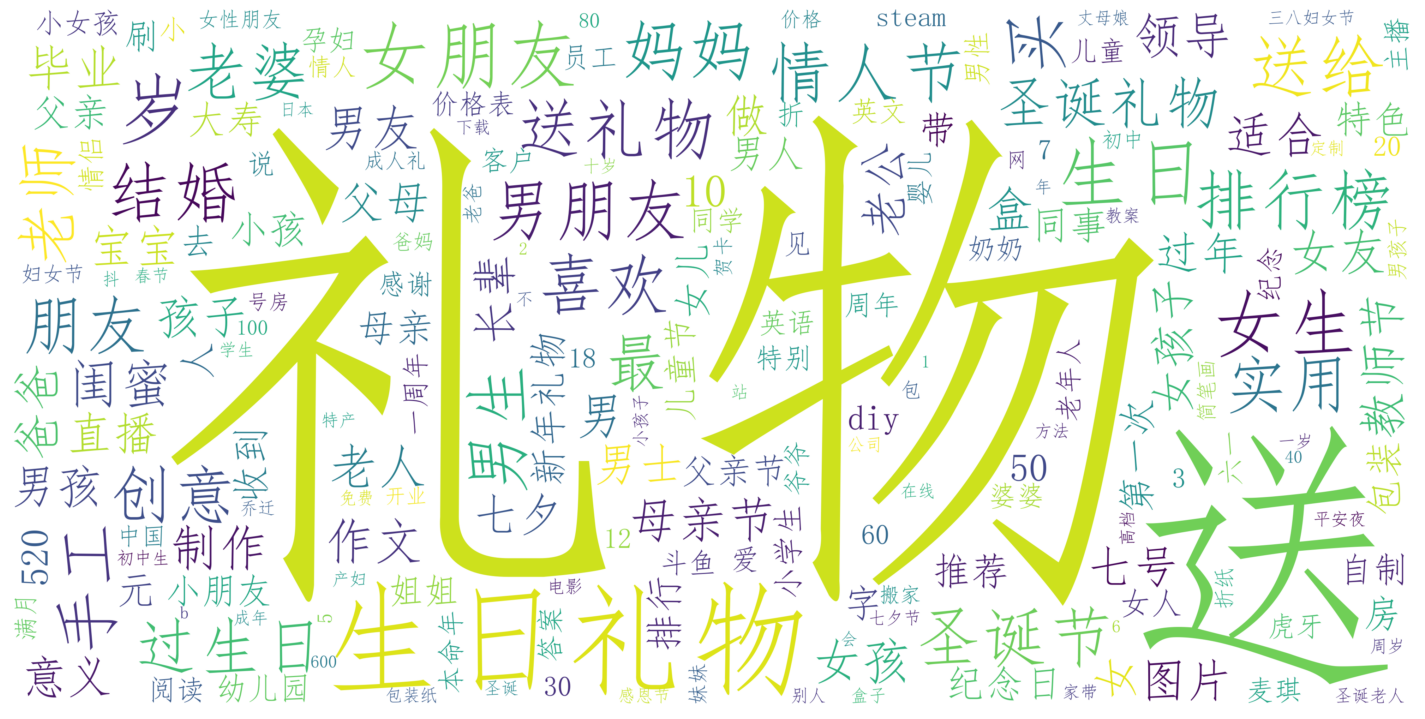

In [67]:
# 词频展示
print ('\n开始制作词云……')                    # 提示当前状态
# mask = numpy.array(Image.open(background))      # 定义词频背景

# my_wordcloud = WordCloud(scale=4,font_path=font,mask=image,stopwords=sw,background_color='white',
#                          max_words = 100,max_font_size = 60,random_state=20).generate(wl_space_split) 
wc = wordcloud.WordCloud(
    scale=10,
    font_path = 'C:/Windows/Fonts/simfang.ttf', # 设置字体（这里选择“仿宋”）
    background_color='white',                   # 背景颜色
#     mask = mask,                                # 文字颜色+形状（有mask参数再设定宽高是无效的）
#     max_words = number,                         # 显示词数
    max_font_size = 150                         # 最大字号
)

wc.generate_from_frequencies(word_counts)                                        # 从字典生成词云
# wc.recolor(color_func=wordcloud.ImageColorGenerator(mask))                       # 将词云颜色设置为背景图方案
plt.figure('词云')                                                             # 弹框名称与大小
plt.figure(figsize=(20, 10.5))



plt.subplots_adjust(top=0.99,bottom=0.01,right=0.99,left=0.01,hspace=0,wspace=0) # 调整边距
plt.imshow(wc, cmap=plt.cm.gray, interpolation='bilinear')                       # 处理词云
plt.axis('off')                                                                  # 关闭坐标轴
plt.savefig('礼物.jpg')
plt.show()  


In [216]:
word_corpos['word'].tolist()

['礼物礼物',
 '什么礼物',
 '礼物送什么',
 '送什么礼物',
 '礼物生日',
 '生日礼物礼物',
 '生日礼物',
 '朋友礼物',
 '什么礼物好',
 '送什么礼物好',
 '礼物送什么好',
 '送朋友礼物',
 '女生礼物',
 '生日送什么礼物',
 '送生日礼物',
 '孩子礼物',
 '男朋友礼物',
 '收到礼物',
 '女朋友礼物',
 '买什么礼物',
 '男生礼物',
 '礼物男生',
 '妈妈礼物',
 '直播礼物',
 '作文礼物',
 '礼物作文',
 '作文.礼物',
 '老师礼物',
 '情人礼物',
 '女孩礼物',
 '手工礼物',
 '送朋友什么礼物',
 '一什么礼物',
 '母亲礼物',
 '七夕礼物',
 '送什么生日礼物',
 '生日礼物送什么',
 '礼物的作文',
 '礼物送女生',
 '教师礼物',
 '送女生礼物',
 '结婚礼物',
 '学生礼物',
 '好的礼物',
 '男友礼物',
 '毕业礼物',
 '闺蜜礼物',
 '妈妈的礼物',
 '送女朋友礼物',
 'qq礼物',
 '老公礼物',
 '送孩子礼物',
 '制作礼物',
 '礼物制作',
 '情人节礼物',
 '快手礼物',
 '我的礼物',
 '送男朋友礼物',
 '女友礼物',
 '儿童礼物',
 '送男生礼物',
 '送朋友的礼物',
 '生日送什么礼物好',
 '礼物图片',
 '孩子的礼物',
 '男孩礼物',
 '一个礼物',
 '礼物英语',
 '男人礼物',
 '女生的礼物',
 '小孩礼物',
 '圣诞礼物',
 '最好的礼物',
 '老婆礼物',
 '父亲礼物',
 '送女孩礼物',
 '宝宝礼物',
 '爸爸礼物',
 '主播礼物',
 '抖音礼物',
 '幼儿园礼物',
 '领导礼物',
 '老人礼物',
 '礼物英文',
 '女儿礼物',
 '女人礼物',
 '送孩子什么礼物',
 '男生的礼物',
 '小学礼物',
 '老师的礼物',
 '六一礼物',
 '男朋友的礼物',
 '送妈妈礼物',
 '父母礼物',
 '送女生什么礼物',
 '婚礼礼物',
 '过生日送什么礼物',
 '新年礼物',
 '女朋友的礼物',
 '送闺蜜礼物',
 '母亲的礼物',
 '送女孩什么礼物',
 '女孩子礼物',


#### 使用keans聚类

In [219]:
# coding=utf-8  
import re          
import os  
import sys
import codecs
import shutil
from sklearn import feature_extraction  
from sklearn.feature_extraction.text import TfidfTransformer  
from sklearn.feature_extraction.text import CountVectorizer
 
'''
sklearn里面的TF-IDF主要用到了两个函数：CountVectorizer()和TfidfTransformer()。
    CountVectorizer是通过fit_transform函数将文本中的词语转换为词频矩阵。
    矩阵元素weight[i][j] 表示j词在第i个文本下的词频，即各个词语出现的次数。
    通过get_feature_names()可看到所有文本的关键字，通过toarray()可看到词频矩阵的结果。
    TfidfTransformer也有个fit_transform函数，它的作用是计算tf-idf值。
'''
def Word2Vectorizer():

    #将文本中的词语转换为词频矩阵 矩阵元素a[i][j] 表示j词在i类文本下的词频
    vectorizer = CountVectorizer(stop_words=stopwords)
 
    #该类会统计每个词语的tf-idf权值
    transformer = TfidfTransformer()
 
    #第一个fit_transform是计算tf-idf 第二个fit_transform是将文本转为词频矩阵
    tfidf = transformer.fit_transform(vectorizer.fit_transform(corpus))
 
    #获取词袋模型中的所有词语  
    word = vectorizer.get_feature_names()
 
    #将tf-idf矩阵抽取出来，元素w[i][j]表示j词在i类文本中的tf-idf权重
    weight = tfidf.toarray()
 
    resName = "礼物Tfidf_Result.txt"
    result = codecs.open(resName, 'w', 'utf-8')
    for j in range(len(word)):
        result.write(word[j] + ' ')
    result.write('\r\n\r\n')
 
    #打印每类文本的tf-idf词语权重，第一个for遍历所有文本，第二个for便利某一类文本下的词语权重  
    for i in range(len(weight)):
        print(u"-------这里输出第",i,u"类文本的词语tf-idf权重------"  )
        for j in range(len(word)):
            result.write(str(weight[i][j]) + ' ')
        result.write('\r\n\r\n')
 
    result.close()

In [220]:
words_document
Word2Vectorizer()

TypeError: Word2Vectorizer() takes 0 positional arguments but 1 was given

#### 文本聚类
* 使用自己分词并清洗后的词转换为词频向量
* 使用LDA进行聚类

In [68]:
used_df.head()


,word,lenword_count,searched_day,word_split
937,礼物礼物,4466347.0,1,礼物n 礼物n
3,礼物,4466347.0,761,礼物n
942,礼物的,1339503.0,1,礼物n
941,的礼物,1339503.0,2,礼物n
236,什么礼物,1133560.0,4,礼物n


In [69]:
print(len(word_split))

24096


In [70]:
# 构建词频向量
def count_frequency(corpus, in_file):
    """
    构建词频向量，并保存。
    输入：语料库的所有有效单词
    """
    if os.path.exists(in_file):
        cnt_vector = joblib.load(in_file)
        cnt_tf = cnt_vector.transform(corpus)
    else:
        cnt_vector = CountVectorizer()
        cnt_tf = cnt_vector.fit_transform(corpus)
        print('主题词袋：', len(cnt_vector.get_feature_names()))
        joblib.dump(cnt_vector, in_file)
    return cnt_tf



In [74]:
# 保存词频向量，用于后面的计算
wordv_file = './礼物WordCountVectorizer.pkl'
wordv_list = count_frequency(word_split, wordv_file)

In [75]:
# lda模型
def lda_fit_transform(in_model, model_in_data):
    """
    使用LDA模型训练语料库，并对文本进行聚类
    """
    if os.path.exists(in_model):
        lda = joblib.load(in_model)
        res = lda.transform(model_in_data)
    else:
        # LDA主题模型
        lda = LatentDirichletAllocation(n_components=100,  # 主题个数
                                        max_iter=200,    # EM算法的最大迭代次数
                                        # learning_method='online',
#                                         learning_offset=50.,  # 仅仅在算法使用online时有意义，取值要大于1。用来减小前面训练样本批次对最终模型的影响
                                        random_state=0)
        res = lda.fit_transform(model_in_data)
        joblib.dump(lda, in_model)
    return res



In [76]:
# 训练lda模型并保存
lda_model_file = "./lda_model.pk"
docres = lda_fit_transform(lda_model_file, wordv_list)


In [77]:
print(docres)

[[0.005 0.005 0.005 ... 0.005 0.005 0.005]
 [0.005 0.005 0.005 ... 0.005 0.005 0.005]
 [0.005 0.005 0.005 ... 0.005 0.005 0.005]
 ...
 [0.01  0.01  0.01  ... 0.01  0.01  0.01 ]
 [0.01  0.01  0.01  ... 0.01  0.01  0.01 ]
 [0.01  0.01  0.01  ... 0.01  0.01  0.01 ]]


In [85]:
from gensim import corpora, models

In [135]:
used_df.head()


,word,lenword_count,searched_day,word_split
937,礼物礼物,4466347.0,1,礼物n 礼物n
3,礼物,4466347.0,761,礼物n
942,礼物的,1339503.0,1,礼物n
941,的礼物,1339503.0,2,礼物n
236,什么礼物,1133560.0,4,礼物n


In [98]:
word_split = [word_split]
word_split

[[['礼物',
   '礼物',
   '礼物',
   '礼物',
   '礼物',
   '礼物',
   '礼物',
   '送',
   '送',
   '礼物',
   '礼物',
   '生日',
   '生日礼物',
   '礼物',
   '生日礼物',
   '朋友',
   '礼物',
   '送礼物',
   '礼物',
   '买',
   '礼物',
   '礼物',
   '送',
   '送',
   '礼物',
   '送',
   '朋友',
   '礼物',
   '女生',
   '礼物',
   '生日',
   '送',
   '礼物',
   '送',
   '生日礼物',
   '孩子',
   '礼物',
   '刷',
   '礼物',
   '男朋友',
   '礼物',
   '收到',
   '礼物',
   '女朋友',
   '礼物',
   '买',
   '礼物',
   '礼物',
   '男生',
   '礼物',
   '礼物',
   '男生',
   '妈妈',
   '礼物',
   '直播',
   '礼物',
   '作文',
   '礼物',
   '礼物',
   '作文',
   '作文',
   '礼物',
   '老师',
   '礼物',
   '情人',
   '礼物',
   '女孩',
   '礼物',
   '手工',
   '礼物',
   '送',
   '朋友',
   '礼物',
   '礼物',
   '母亲',
   '礼物',
   '七夕',
   '礼物',
   '礼物',
   '男',
   '送',
   '生日礼物',
   '生日礼物',
   '送',
   '礼物',
   '作文',
   '礼物',
   '送',
   '女生',
   '教师',
   '礼物',
   '送',
   '女生',
   '礼物',
   '礼物',
   '说',
   '结婚',
   '礼物',
   '学生',
   '礼物',
   '礼物',
   '盒',
   '礼物',
   '礼物',
   '女',
   '男友',
   '礼物',
   '毕业',
   '礼物',
   '闺蜜',
   '礼物',
   '妈妈'

In [147]:
document = used_df[(used_df.word.str.len() > 3) & (used_df.word.str.len() < 20)]
document.head()

,word,lenword_count,searched_day,word_split
937,礼物礼物,4466347.0,1,礼物n 礼物n
236,什么礼物,1133560.0,4,礼物n
946,礼物送什么,613979.0,1,礼物n 送v
188,送什么礼物,613979.0,11,送v 礼物n
947,礼物生日,562027.0,1,礼物n 生日t


In [151]:
document.count()

word             7156
lenword_count    7150
searched_day     7150
word_split       7156
dtype: int64

In [154]:
document_list = document['word'].tolist()


In [222]:
# 生成语料词典
dictionary = corpora.Dictionary(words_all)
# print(dictionary)
# 生成稀疏向量集
corpus = [dictionary.doc2bow(words) for words in words_all]
# print(corpus)
# LDA模型，num_topics设置聚类数，即最终主题的数量
lda = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=40)
# 展示每个主题的前5的词语
# for topic in lda.print_topics():
#     for i in topic:
#         print(i)
for i in range(0, lda.num_topics-1):
    print(lda.print_topic(i))

# 推断每个语料库中的主题类别
result_df = []
print('结果分类情况：')
for e, values in enumerate(lda.inference(corpus)[0]):
#     print(values)
    topic_val = 0
    topic_id = 0
    for tid, val in enumerate(values):
        if val > topic_val:
            topic_val = val
            topic_id = tid
    result_df.append([document_list[e],topic_id])
    print(topic_id, '->', document_list[e])

0.251*"礼物" + 0.160*"妈妈" + 0.139*"送" + 0.125*"结婚" + 0.045*"小学生" + 0.044*"小" + 0.039*"纪念日" + 0.034*"母亲节" + 0.034*"贺卡" + 0.018*"周岁"
0.284*"礼物" + 0.188*"送" + 0.122*"适合" + 0.046*"大寿" + 0.044*"男士" + 0.044*"父母" + 0.030*"老人" + 0.028*"满月" + 0.020*"80" + 0.016*"女性"
0.259*"礼物" + 0.186*"送" + 0.079*"成人礼" + 0.057*"小女孩" + 0.044*"奶奶" + 0.039*"男性" + 0.038*"朋友" + 0.019*"节" + 0.018*"过生日" + 0.018*"教师"
0.278*"礼物" + 0.238*"送" + 0.108*"女友" + 0.048*"小朋友" + 0.048*"儿童节" + 0.035*"六一" + 0.033*"妹妹" + 0.028*"婆婆" + 0.020*"万圣节" + 0.020*"七夕节"
0.534*"礼物" + 0.060*"元" + 0.057*"直播" + 0.048*"本命年" + 0.042*"虎牙" + 0.037*"价格" + 0.030*"100" + 0.025*"分成" + 0.016*"产妇" + 0.014*"送"
0.331*"礼物" + 0.159*"送" + 0.080*"孩子" + 0.079*"人" + 0.064*"毕业" + 0.058*"刷" + 0.029*"高档" + 0.014*"老师" + 0.014*"新生儿" + 0.008*"ppt"
0.222*"礼物" + 0.152*"50" + 0.125*"图片" + 0.093*"同学" + 0.073*"岁" + 0.073*"特色" + 0.066*"送" + 0.050*"日本" + 0.012*"吉他谱" + 0.011*"毕业"
0.411*"生日礼物" + 0.263*"送" + 0.135*"男朋友" + 0.036*"妈妈" + 0.022*"女朋友" + 0.014*"爸爸" + 0.011*"十八岁" + 0.009*"

IndexError: list index out of range

In [181]:
print(pd.DataFrame(result_df,columns=['words','class']))
print(pd.DataFrame(result_df,columns=['words','class']).groupby('class').count())
pd.DataFrame(result_df,columns=['words','class']).to_csv('words_class_LDA10.csv')

                  words  class
0                  礼物礼物      5
1                  什么礼物      5
2                 礼物送什么      5
3                 送什么礼物      5
4                  礼物生日      5
...                 ...    ...
7151          送什么礼物比较好呢      3
7152            书包衣服不必了      1
7153  不知道老人都喜欢什么?送什么礼物?      4
7154        我和女朋友认识一百天了      5
7155   第一次去女朋友家带什么礼物比较好      9

[7156 rows x 2 columns]
       words
class       
0        407
1       1120
2        915
3        463
4       1173
5       1064
6        500
7        416
8        548
9        550


In [ ]:
# 对分类结果进行分组，不同的类别分开保存


In [90]:
import jieba
import jieba.posseg as jp
from gensim import corpora, models

# Global Dictionary
new_words = ['奥预赛', '折叠屏']  # 新词
stopwords = {' ', '再', '的', '们', '为', '时', '：'}  # 停用词
synonyms = {'韩国': '南朝鲜', '传言': '流言'}  # 同义词
words_nature = ('n', 'nr', 'ns', 'nt', 'eng', 'v', 'd')  # 可用的词性


def add_new_words():  # 增加新词
    for i in new_words:
        jieba.add_word(i)


def remove_stopwords(ls):  # 去除停用词
    return [word for word in ls if word not in stopwords]


def replace_synonyms(ls):  # 替换同义词
    return [synonyms[i] if i in synonyms else i for i in ls]


documents = [
    '足协申请取消女足奥预赛韩国主场比赛 公平原则保障安全',
    '芬森发声再回应传言：想念辽宁队友 为中国的球迷们祈福',
    '电商围剿涉疫商家进行时：哄抬物价，就这么罚你',
    '今晚视频直播华为新品发布会：全新折叠屏手机亮相']
add_new_words()
words_ls = []
for text in documents:
    words = replace_synonyms(remove_stopwords([w.word for w in jp.cut(text)]))
    words_ls.append(words)
print(words_ls)
# 生成语料词典
dictionary = corpora.Dictionary(words_ls)
print(dictionary)
# 生成稀疏向量集
corpus = [dictionary.doc2bow(words) for words in words_ls]
# LDA模型，num_topics设置聚类数，即最终主题的数量
lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=2)
# 展示每个主题的前5的词语
for topic in lda.print_topics(num_words=5):
    print(topic)
# 推断每个语料库中的主题类别
print('推断：')
for e, values in enumerate(lda.inference(corpus)[0]):
    topic_val = 0
    topic_id = 0
    for tid, val in enumerate(values):
        if val > topic_val:
            topic_val = val
            topic_id = tid
    print(topic_id, '->', documents[e])


[['足协', '申请', '取消', '女足', '奥预赛', '南朝鲜', '主场', '比赛', '公平', '原则', '保障', '安全'], ['芬森', '发声', '回应', '流言', '想念', '辽宁', '队友', '中国', '球迷', '祈福'], ['电商', '围剿', '涉疫', '商家', '进行', '哄抬物价', '，', '就', '这么', '罚', '你'], ['今晚', '视频', '直播', '华为', '新品', '发布会', '全新', '折叠屏', '手机', '亮相']]
Dictionary(43 unique tokens: ['主场', '保障', '公平', '南朝鲜', '原则']...)
(0, '0.027*"进行" + 0.027*"电商" + 0.027*"你" + 0.027*"这么" + 0.027*"公平"')
(1, '0.035*"发声" + 0.034*"球迷" + 0.033*"回应" + 0.032*"中国" + 0.032*"队友"')
推断：
0 -> 足协申请取消女足奥预赛韩国主场比赛 公平原则保障安全
1 -> 芬森发声再回应传言：想念辽宁队友 为中国的球迷们祈福
0 -> 电商围剿涉疫商家进行时：哄抬物价，就这么罚你
0 -> 今晚视频直播华为新品发布会：全新折叠屏手机亮相


In [ ]:
# 构造文本的词袋
def get_all_vector(file_path,stop_words_set):
    names = [ os.path.join(file_path,f) for f in os.listdir(file_path) ]
    posts = [ open(name).read() for name in names ]
    docs = []
    word_set = set()
    for post in posts:
        doc = del_stop_words(post,stop_words_set)
        docs.append(doc)
        word_set |= set(doc)
        #print len(doc),len(word_set)

    word_set = list(word_set)
    docs_vsm = []
    #for word in word_set[:30]:
        #print word.encode("utf-8"),
    for doc in docs:
        temp_vector = []
        for word in word_set:
            temp_vector.append(doc.count(word) * 1.0)
        #print temp_vector[-30:-1]
        docs_vsm.append(temp_vector)

    docs_matrix = np.array(docs_vsm)

In [192]:
from sklearn.cluster import k_means_
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.preprocessing import StandardScaler


def create_cluster(sparse_data, nclust = 10):

    # Manually override euclidean
    def euc_dist(X, Y = None, Y_norm_squared = None, squared = False):
        #return pairwise_distances(X, Y, metric = 'cosine', n_jobs = 10)
        return cosine_similarity(X, Y)
    k_means_.euclidean_distances = euc_dist
    
    scaler = StandardScaler(with_mean=False)
    sparse_data = scaler.fit_transform(sparse_data)
    kmeans = k_means_.KMeans(n_clusters = nclust, n_jobs = 20, random_state = 3425)
    _ = kmeans.fit(sparse_data)
    return kmeans.labels_

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from Bio.Cluster import kcluster
from Bio.Cluster import clustercentroids
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
data=np.load('/home/philochan/ResExp/genderkernel/1.npy')
coef = []
x=range(3,20)
for clusters in x:
    clusterid, error, nfound = kcluster(data, clusters, dist='u',npass=100)
    silhouette_avg = silhouette_score(data, clusterid, metric = 'cosine')
    coef.append(silhouette_avg)
  
e =[i+3 for i,j in enumerate(coef) if j == max(coef)]
print e
print coef
plt.plot(x,coef)
plt.show()